<a href="https://colab.research.google.com/github/claredavies/Image3DCoursework/blob/main/WarpAffine/WarpAffine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warp Affine Transformations

## Task

Given a document image transform it to a scanner like perspective.

Use your own document image.

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [7]:
!git clone https://github.com/claredavies/Image3DCoursework.git

Cloning into 'Image3DCoursework'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 158 (delta 2), reused 0 (delta 0), pack-reused 150
Receiving objects: 100% (158/158), 26.57 MiB | 18.28 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [8]:
%cd Image3DCoursework/WarpAffine

/content/Image3DCoursework/WarpAffine/Image3DCoursework/WarpAffine


In [9]:
img = cv2.imread("input/input.jpg")
im_scanned = cv2.imread("input/scanned.jpg")

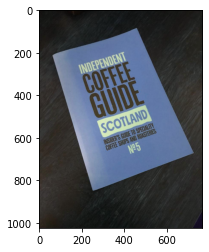

In [10]:
fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(img);

## Scan Documents using Warp Affine

In [11]:
def orderPoints(points):
  # Rearrange coordinates to order:
    rectangle = np.zeros((4, 2), dtype='float32')
    points = np.array(points)
    s = points.sum(axis=1)

    rectangle[0] = points[np.argmin(s)]
    rectangle[2] = points[np.argmax(s)]
 
    diff = np.diff(points, axis=1)
    rectangle[1] = points[np.argmin(diff)]
    rectangle[3] = points[np.argmax(diff)]

    return rectangle.astype('int').tolist()

In [12]:
def find_dest(pts):
    (tl, tr, br, bl) = pts

    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    destinationCorners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
 
    return orderPoints(destinationCorners)

In [13]:
def morpholigicalOpening(image):
  kernel = np.ones((5, 5), np.uint8)
  image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=3)
  return image

In [14]:
def imageResizing(image):
  dimLimit = 1080
  maxDim = max(image.shape)
  if maxDim > dimLimit:
      resizeScale = dimLimit / maxDim
      image = cv2.resize(image, None, fx=resizeScale, fy=resizeScale)
  return image

In [15]:
def grabCut(img):
  mask = np.zeros(img.shape[:2], np.uint8)
  bgdModel = np.zeros((1, 65), np.float64)
  fgdModel = np.zeros((1, 65), np.float64)
  rectangle = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
  cv2.grabCut(img, mask, rectangle, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
  img = img * mask2[:, :, np.newaxis]
  return [mask, mask2, img]

In [16]:
def findCorners(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (11, 11), 0)
  
  # Perform Edge Detection.
  canny = cv2.Canny(gray, 0, 200)
  canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

  # Finding contours for the detected edges.
  contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  # Keeping only the largest detected contour.
  page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

  if len(page) == 0:
      return img
  for c in page:
      epsilon = 0.02 * cv2.arcLength(c, True)
      corners = cv2.approxPolyDP(c, epsilon, True)
      # If our approximated contour has four points.
      if len(corners) == 4:
          break

  # Sorting the corners and converting them to desired shape.
  corners = sorted(np.concatenate(corners).tolist())
  corners = orderPoints(corners)

  return corners

In [17]:
def scan(image):
    # Resize image to workable size
    image = imageResizing(image)

    # Create a copy of resized original image for later use
    orig_img = image.copy()

    # Repeated Closing operation to remove text from the document.
    image = morpholigicalOpening(image)
    # GrabCut
    [mask, mask2, image] = grabCut(image)

    corners = findCorners(image)
 
    destination_corners = find_dest(corners)
 
    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    warpAffineScan = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]),
                                flags=cv2.INTER_LINEAR)
    return warpAffineScan

In [18]:
warpAffineScan = scan(img)

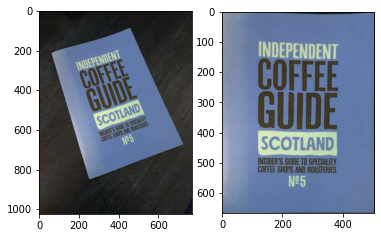

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img);
ax2.imshow(warpAffineScan);